In [86]:
"""
Author:
Cameron Smither, American Institutes for Research

Purpose:
Use institution 3175's student, progression, and cost data to attempt to build 
"Progression Profiles" for CBE students using behavioral information (course
and cost). We will (attempt to) use cluster analysis to see what natural 
patterns appear in enrollment data related to student outcomes with the 
ultimate goal of creating "Profiles" of students (or, a process to build them) 
that institutions could use to better understand and support their students.

This work will connect with the work of institutions using non-behavioral data
(e.g. students' intentions) to attempt to profile.


Change log:
#--------------------------------------------------------------------------------
# 2018-06-04.1 | CS | Initial file created
# 2018-07-25.2 | CS+TN | Finished data import syntax
# 2018-07-30.3 | CS+TN | Begin clustering 
# 2018-08-10.4 | TN | Started period-level cost data integration
#--------------------------------------------------------------------------------
"""

'\nAuthor:\nCameron Smither, American Institutes for Research\n\nPurpose:\nUse institution 3175\'s student, progression, and cost data to attempt to build \n"Progression Profiles" for CBE students using behavioral information (course\nand cost). We will (attempt to) use cluster analysis to see what natural \npatterns appear in enrollment data related to student outcomes with the \nultimate goal of creating "Profiles" of students (or, a process to build them) \nthat institutions could use to better understand and support their students.\n\nThis work will connect with the work of institutions using non-behavioral data\n(e.g. students\' intentions) to attempt to profile.\n\n\nChange log:\n#--------------------------------------------------------------------------------\n# 2018-06-04.1 | CS | Initial file created\n# 2018-07-25.2 | CS+TN | Finished data import syntax\n# 2018-07-30.3 | CS+TN | Begin clustering \n# 2018-08-10.4 | TN | Started period-level cost data integration\n#-------------

In [87]:
# Import needed modules
import os
import pandas as pd
import numpy as np
import sklearn as skl
from sklearn.preprocessing import StandardScaler #For normalizing the sample data
#Import the PCA (Principal Component Analysis) package for project it to a lower dimensional space
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt #PyPlot for building scatterplots (+related style code)
plt.style.use('seaborn-whitegrid')
from sklearn.cluster import KMeans #Import the KMeans clustering module

In [88]:
# Set up some global references that will be helpful throughout; update for subsequent institutions
inst_id = "3175"
inst_dir = 'Z:\\Lumina - CBE Evaluation\\02 Data\\Analysis\\Capella-3175'


# Change dir to where inst's data are stored
os.chdir(inst_dir)
os.getcwd()
#os.listdir()

'Z:\\Lumina - CBE Evaluation\\02 Data\\Analysis\\Capella-3175'

In [89]:
## Prep inst's Student data
stud_df = pd.read_stata(str(inst_dir+'\\Student\\'+inst_id+'_Student_v1_cap.dta'))

# view data
#stud_df.head()
#stud_df.describe()
print (stud_df[:0]) #view elements

# Delete elements we don't want/need
# BE CAREFUL WITH RACETH (Capella shared raceth as (string) numbers like we wanted, raceth_int not needed)
stud_df.drop(['inst_id', 'sex', 'myob', 'forres_ind', 'raceth_int', 'prior_pse_amttype', 'prior_pse_credential', 
                     'mil_res_ae', 'vet_ae', 'ftft_flag', 'employed_ae', 'remed', 'pell_elig', 'pell_recip',
                     'debt_ae_bin', 'unemploy', 'status', 'trnsfroutcbe', 'trnsfrincbe'], inplace=True, axis=1) 

print(stud_df.head())

Empty DataFrame
Columns: [inst_id, stud_id, cohort, sex, myob, zip, forres_ind, raceth, prior_pse_amt, prior_pse_amttype, prior_pse_credential, start, mil_res_ae, vet_ae, ftft_flag, employed_ae, remed, pell_elig, pell_recip, debt_ae, unemploy, status, trnsfroutcbe, trnsfrincbe, z_sex, z_start, age, age_bin, z_forres, raceth_int, z_white, z_black, z_hisp, z_asian, z_2plus, z_missrace, z_orace, prior_pse_amt_bin, z_prior_cred, z_milres, z_vet, z_ftft, z_employed, z_remed, z_pelle, z_pellr, debt_ae_bin]
Index: []

[0 rows x 47 columns]
         stud_id cohort    zip raceth  prior_pse_amt     start  debt_ae  \
0   CBE1_7031283   CBE1  00646      9             86  20141013      NaN   
1  Comp1_7082398  Comp1  00680      1             90  20141110      NaN   
2  Comp1_7147400  Comp1  00718      4             12  20141208   3511.0   
3  Comp1_6716133  Comp1  00725      1             84  20131007   8230.0   
4   CBE1_7142157   CBE1  00730      1             90  20150202      NaN   

   z_sex  

In [90]:
## Prep inst's Progression data
prog_df = pd.read_stata(str(inst_dir+'\\Analysis\\'+inst_id+'_progression_MASTER.dta'),)

# view data
#prog_df.head()
#print (prog_df[:0]) #view elements

# columns 0-6   (stud_id ... age) are student characteristics
# columns 7-8   (retain*) are retention indicators
# columns 9-18  (avail_p*) describe the number of attempted units, by period
# columns 19-28 (earn_p*) describe the number of earned units, by period
# columns 29-34 (prior_group ... tt_cred) reflect share of program completed in units at entry and time to milestone values
# columns 35-44 (ratio_p*) describe the ratio of units earned vs attempted
# columns 45-70 (p*) describe the running cumulative share of their program accumulated by+during that period
# columns 71-93 (earned*) describe the share of their program accumulated in *each individual* period
# columns 94-99 (ever_cred ... inst_id) some additional elements. Keep only ever_cred (completion flag) 
#               and ETC (elapsed time to credential)

#print (prog_df.iloc[0:0,94:]) # view specific element names
#prog_df['uniqueid'].value_counts() # check specific element values

del_list = list(range(1,70)) + list(range(85,100))
prog_df.drop(prog_df.columns[[del_list]], axis=1, inplace=True) #delete elements we don't want/need

print (prog_df[:0]) #view elements


Empty DataFrame
Columns: [stud_id, earned1, earned2, earned3, earned4, earned5, earned6, earned7, earned8, earned9, earned10, earned11, earned12, earned13, earned14, earned15]
Index: []


In [91]:
## Prep inst's Cost data
cost_df = pd.read_stata(str(inst_dir+'\\Analysis\Cost analyses\\cost_calculated.dta'),)

# view data
#cost_df.head()

keep_list = ['stud_id', 'pct_charges_grants', 'pct_charges_loans', 'pct_charges_unknown']
cost_df = cost_df[keep_list] #keep only elements we want/need

print (cost_df[:0]) #view elements

Empty DataFrame
Columns: [stud_id, pct_charges_grants, pct_charges_loans, pct_charges_unknown]
Index: []


In [92]:
## Bringing in by period shares of loans, grants, etc
cost_progdf = pd.read_stata(str(inst_dir+'\\Analysis\Cost analyses\\cost_progression.dta'),)

## making sure we got it in correctly 
cost_progdf.head()

keep_me = ['stud_id', 'period', 'pct_charges_loans', 'pct_charges_grants', 'pct_charges_unknown']
cost_progdf=cost_progdf[keep_me]


##reshaping 
#table = cost_progdf.pivot(index='stud_id',columns='period',values='Value')  

cost_progdf = cost_progdf.pivot(index='stud_id', columns='period')
# fix the hierarchical column names thing
cost_progdf.columns = [s1 + str(s2) for (s1,s2) in cost_progdf.columns.tolist()]
cost_progdf.reset_index(inplace=True)

for x in range(1,16): 
   var ="pct_charges_loans%d" % (x)
   newname = "enrolled%d" % (x)
   #print(var)
   cost_progdf.loc[cost_progdf[var]>0.0, var]=1
   cost_progdf.rename(columns={var : newname}, inplace =True)

cost_progdf.drop(cost_progdf.columns[15:46], axis=1, inplace=True)
cost_progdf =cost_progdf.fillna(0)

print(cost_progdf[:0])
#cost_progdf.head()

Empty DataFrame
Columns: [stud_id, enrolled1, enrolled2, enrolled3, enrolled4, enrolled5, enrolled6, enrolled7, enrolled8, enrolled9, enrolled10, enrolled11, enrolled12, enrolled13, enrolled14]
Index: []


In [93]:
## Create a master df
# Student + progression
master_df = stud_df.set_index('stud_id').join(prog_df.set_index('stud_id'))

# (Student + progression) + cost
master_df = master_df.join(cost_df.set_index('stud_id'))

## we should add second cost here
master_df = master_df.join(cost_progdf.set_index('stud_id'))

# change the index from stud_id to just a normal index
master_df.index.name = 'stud_id'
master_df.reset_index(inplace=True)

print (master_df[:0]) #view elements
#master_df['cohort']

Empty DataFrame
Columns: [stud_id, cohort, zip, raceth, prior_pse_amt, start, debt_ae, z_sex, z_start, age, age_bin, z_forres, z_white, z_black, z_hisp, z_asian, z_2plus, z_missrace, z_orace, prior_pse_amt_bin, z_prior_cred, z_milres, z_vet, z_ftft, z_employed, z_remed, z_pelle, z_pellr, earned1, earned2, earned3, earned4, earned5, earned6, earned7, earned8, earned9, earned10, earned11, earned12, earned13, earned14, earned15, pct_charges_grants, pct_charges_loans, pct_charges_unknown, enrolled1, enrolled2, enrolled3, enrolled4, enrolled5, enrolled6, enrolled7, enrolled8, enrolled9, enrolled10, enrolled11, enrolled12, enrolled13, enrolled14]
Index: []

[0 rows x 60 columns]


In [99]:
## SCI-KIT ATTEMPTS v2
# First, keep CBE students only and the variables we're going to use
master_cbedf = master_df[master_df.cohort == 'CBE1']
master_cbedf.reset_index(inplace=True)

master_cbedf = master_cbedf.drop(['zip', 'start', 'age_bin','z_start', 'prior_pse_amt_bin', 'z_pelle','raceth','z_remed','z_milres','pct_charges_grants', 'pct_charges_loans',
       'pct_charges_unknown'], axis=1)
#del_master_list = list(range(0,1)) + list(range(2,5)) + list(range(6,10)) + list(range(11, 29))
# REAL_list = master_cbedf.columns[del_master_list]
# master_cbedf.drop(REAL_list, axis=1, inplace=True)
#print(master_cbedf[:0])
#master_cbedf.describe()

# Filling NaNs in debt and other vars 
master_cbedf=master_cbedf.fillna(0)


# Now pull a sample of the observations for the elements we want to include
sample_df_raw = master_cbedf.sample(frac=.5)

# Reset sample index for proper sorting
sample_df_raw.reset_index(inplace=True)
#sample_df_raw.describe()

## no columns null at this point 
#sample_df_raw.isnull().any()


# Normalize in advance so we can PCA accurately
norm_vars = list(range(4,50))
#print(sample_df_raw.columns[norm_vars])
sample_df_std = sample_df_raw.filter(items=sample_df_raw.columns[norm_vars])


sample_df_std=  (sample_df_std - sample_df_std.mean()) / (sample_df_std.max() - sample_df_std.min())
print(sample_df_std)
sample_df_std.isnull().any()
# # GOOD SO FAR
# ##############################################################################################################################
# # Conduct PCA (principcal components analysis) to 
# pca = PCA(n_components=2)
# pca_data = pca.fit_transform(sample_df_std)
# pca_df = pd.DataFrame(data = pca_data, columns = ['PC1', 'PC2'])

# # Combine PCA data and the stud_id value
# sample_pca_df = sample_df_raw[['stud_id', 'cohort']].join(pca_df)

# #colors = np.where(sample_pca_df["cohort"]=='Comp1','r','-')
# #colors[sample_pca_df["cohort"]=='Comp2'] = 'r'
# #colors[sample_pca_df["cohort"]=='CBE1'] = 'b'
# #colors[sample_pca_df["cohort"]=='CBE2'] = 'b'

# sample_pca_df.plot.scatter(x='PC1',y='PC2')
# #sample_pca_df.plot.scatter(x='PC1',y='PC2', c=colors)

     prior_pse_amt   debt_ae     z_sex       age  z_forres   z_white  \
0        -0.124482 -0.093728  0.328874  0.083043 -0.004459 -0.480491   
1        -0.177815  0.162527 -0.671126 -0.236106 -0.004459  0.519509   
2         0.268852 -0.070378  0.328874  0.338362 -0.004459 -0.480491   
3        -0.024482 -0.093728 -0.671126  0.253256 -0.004459  0.519509   
4        -0.217815 -0.093728 -0.671126  0.146873 -0.004459  0.519509   
5         0.082185 -0.093728  0.328874 -0.129723 -0.004459 -0.480491   
6        -0.017815 -0.093728  0.328874  0.423468 -0.004459  0.519509   
7        -0.271148 -0.093728  0.328874  0.274532 -0.004459  0.519509   
8        -0.017815 -0.093728 -0.671126 -0.065893 -0.004459  0.519509   
9        -0.017815 -0.058010  0.328874  0.231979 -0.004459  0.519509   
10       -0.004482  0.122809  0.328874 -0.002064 -0.004459  0.519509   
11        0.282185  0.085690 -0.671126 -0.214830 -0.004459  0.519509   
12        0.182185  0.064054 -0.671126 -0.129723 -0.004459  0.51

prior_pse_amt    False
debt_ae          False
z_sex            False
age              False
z_forres         False
z_white          False
z_black          False
z_hisp           False
z_asian          False
z_2plus          False
z_missrace       False
z_orace          False
z_prior_cred     False
z_vet            False
z_ftft           False
z_employed       False
z_pellr          False
earned1          False
earned2          False
earned3          False
earned4          False
earned5          False
earned6          False
earned7          False
earned8          False
earned9          False
earned10         False
earned11         False
earned12         False
earned13         False
earned14          True
earned15          True
enrolled1        False
enrolled2        False
enrolled3        False
enrolled4        False
enrolled5        False
enrolled6        False
enrolled7        False
enrolled8        False
enrolled9        False
enrolled10       False
enrolled11       False
enrolled12 

In [184]:
# Start with student characteristics first
kmeans1 = KMeans(n_clusters=2, init='random', algorithm='auto').fit(sample_df_std)
kmeans1.labels_
kmeans1.cluster_centers_

# Does KMeans keep the order of the observations the same????????????????????????????????????????????
kmeans_results = kmeans1.predict(sample_df_std)
kmeans_results = pd.DataFrame(data=kmeans_results, columns=['cluster'])

# Combine kmeans_results and the PCA data
final_df = sample_pca_df.join(kmeans_results)

final_df.head()

,stud_id,cohort,PC1,PC2,cluster
0,Comp2_6986677,Comp2,0.371930,-0.274654,1
1,Comp2_6920591,Comp2,0.495853,-0.339376,1
2,Comp2_7683468,Comp2,0.476871,-0.330179,1
3,Comp1_6998519,Comp1,0.358296,-0.264146,1
4,Comp1_7041440,Comp1,0.385816,-0.274942,1


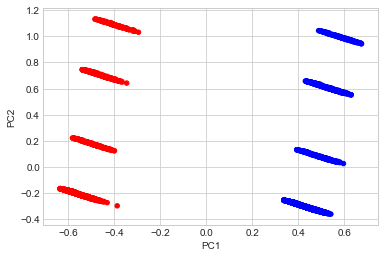

In [185]:
#Visualize using the PCA data!
colors_fin = np.where(final_df['cluster']==0,'r','-')
colors_fin[final_df['cluster']==1] = 'b'

final_df.plot.scatter(x='PC1',y='PC2', c=colors_fin)